# CPSC 536M - Homework 2
Emma Hansen and Naomi Graham

October 2020

In [110]:
# Load packages
using Images, FileIO, ImageMagick, Zygote, Random, LinearAlgebra
using PyPlot

In [167]:
# Functions
function linesearch(grad_f,s,d)
    #alpha_upper0 = 1
    #alpha_lower0 = 0
    alpha_mid = 0.5
    alpha_range = 0.5
    stop = 100
    alpha_storage = zeros(stop+1)
    alpha_storage[1] = alpha_mid
    
    for i=1:stop
        val_mid = dot(-grad_f, alpha_mid * s + (1-alpha_mid) * d) / (norm(grad_f)*norm(alpha_mid * s + (1-alpha_mid) * d))
        alpha_upper = alpha_mid + (1/2)*alpha_range
        alpha_lower = alpha_mid - (1/2)*alpha_range
        
        val_upper = dot(-grad_f, alpha_upper * s + (1-alpha_upper) * d) / (norm(grad_f)*norm(alpha_upper * s + (1-alpha_upper) * d))
        val_lower = dot(-grad_f, alpha_lower * s + (1-alpha_lower) * d) / (norm(grad_f)*norm(alpha_lower * s + (1-alpha_lower) * d))
        
        if val_upper > val_mid # note: I think something is wrong with this criteria...
            alpha_mid = alpha_upper
        elseif val_lower > val_mid
            alpha_mid = alpha_lower
        end
        
#         if val_upper > val_mid # note: something IS wrong with this one...
#             alpha_lower0 = alpha_mid
#             alpha_mid = alpha_upper0
            
#         elseif val_lower > val_mid
#             alpha_upper0 = alpha_mid
#             alpha_mid = alpha_lower0
            
#         else
#             alpha_upper0 = alpha_upper1
#             alpha_lower0 = alpha_lower1
#         end
        
        alpha_range = (1/2) * alpha_range
        alpha_storage[i+1] = alpha_mid
    end
    return alpha_mid, alpha_storage
end
    
    

# to solve <s,grad(f)>
function get_s(D,grad_f)
    m = size(D)[2]
    eps = 0.001
    stop = 100
    
    IP = (-grad_f)' * D
    ind_max = argmax(IP)
    s0 = D[:,ind_max]
    s1 = ones((m,1))
    
    for i=1:stop
        IP = (-grad_f)' * D
        ind_max = argmax(IP)
        d = D[:,ind_max]
        
        alpha, = linesearch(grad_f,s0,d)
        s1 = alpha * s0 + (1-alpha) * d
        
        if norm(s1-s0) <eps
            break
        end
        
        s0 = s1
    end
    
    
    
    
end
        

# Frank-Wolfe

# function to minimize

get_s (generic function with 1 method)

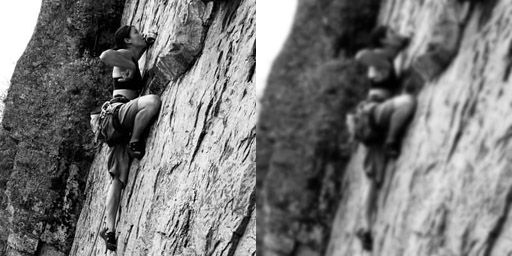

In [3]:
# Load blurry and original images
original_path = "hw2_image256.jpg"
blurry_path = "hw2_image256_blurred.jpg"
original = load(original_path)
blurry = load(blurry_path)

mosaicview(original, blurry; nrow=1)

In [4]:
function normsquared(x)
    return sum(x .^ 2)
end


normsquared (generic function with 1 method)

In [7]:
x = [1,2,3,4]

normsquared(x)
gradient(y -> normsquared(y),x)

([2, 4, 6, 8],)

In [25]:
m = 5
100 .* rand(Float16,(m,1))

5×1 Array{Float16,2}:
  9.96
 83.8
  1.5625
 65.06
 56.25

In [38]:
m = 20
c
I = [i0]
DI = filter((x) -> x != i0, DI)

19-element Array{Int64,1}:
  1
  2
  3
  4
  5
  6
  8
  9
 10
 11
 12
 13
 14
 15
 16
 17
 18
 19
 20

In [70]:
A = rand(Float16,(6,6))
b = rand(Float16,(6,1))

6×1 Array{Float16,2}:
 0.461
 0.3516
 0.8057
 0.416
 0.1846
 0.585

In [73]:
y = b' * A

1×6 Array{Float16,2}:
 1.29  1.289  1.906  1.206  1.375  1.672

In [154]:
grad_f = 2 .* (rand(Float16,(5,1)) .- 0.5) 
s = 2 .* (rand(Float16,(5,1)) .- 0.5)
d = 2 .* (rand(Float16,(5,1)) .- 0.5)
print([grad_f,s,d])

[[0.96484375; -0.197265625; -0.736328125; -0.859375; -0.421875], [-0.248046875; -0.69140625; 0.6796875; 0.203125; -0.5859375], [-0.58984375; 0.99609375; -0.275390625; 0.48828125; -0.76953125]]

In [161]:
grad_f = [-5,-2]
s = [2,4]
d = [6,0]
print([grad_f,s,d])

[[-5, -2], [2, 4], [6, 0]]

In [173]:
alpha_mid, = linesearch(grad_f,s,d)

(0.4285714253783226, [0.5, 0.5, 0.375, 0.4375, 0.4375, 0.421875, 0.4296875, 0.4296875, 0.427734375, 0.4287109375  …  0.4285714253783226, 0.4285714253783226, 0.4285714253783226, 0.4285714253783226, 0.4285714253783226, 0.4285714253783226, 0.4285714253783226, 0.4285714253783226, 0.4285714253783226, 0.4285714253783226])

In [169]:
dot(-grad_f, s)

18

In [170]:
dot(-grad_f, d)

30

In [171]:
norm(s)

4.47213595499958

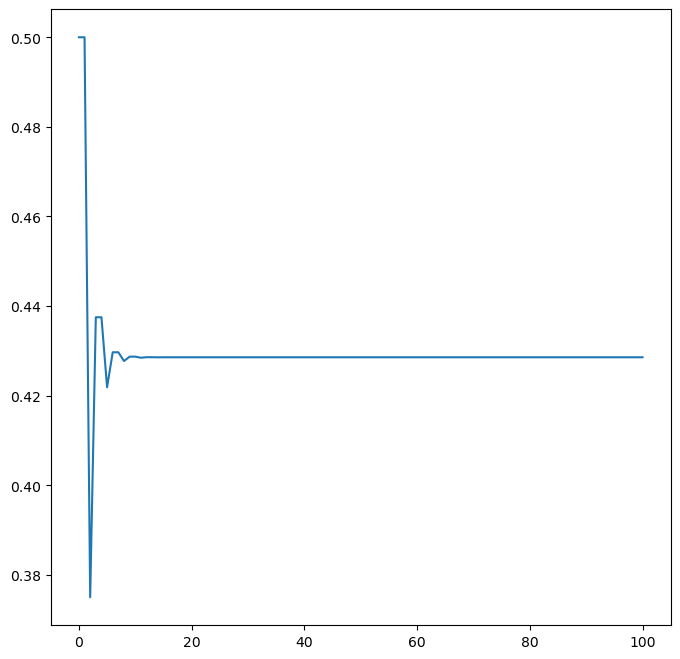

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000033BFD370>

In [172]:
fig = figure(figsize=(8,8))

ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(alpha_storage)